In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import seaborn as sns
%matplotlib inline

In [68]:
#when running the same code twice, create a function
#simple box plot to visually inspect outliers. Describe() works well, but this is quick
def boxplot(df):
    # Boxplot visualization
    plt.figure(figsize=(12, 8))
    df.boxplot(column=['RSI', 'News Sentiment', 'Forward EPS Estimate', 'Economic Index', 'Commodities Price Index', 'Average Precipitation over last month'])
    plt.grid(True)
    plt.show()

In [69]:
#numerically catch outliers from the data where the values > 3 standard deviations, then replace outliers with the median value of the column.
def handle_outliers(df):
    #only columns that have a number in dtype. df.info() confirmed this
    numeric_cols = df.select_dtypes(include=[np.number])
    #SD 3
    threshold = 3
    #get z score from numpy
    z_scores = np.abs(stats.zscore(numeric_cols))
    #boolean flag where Z score > 3 SD
    outliers = pd.DataFrame(z_scores > threshold, columns=numeric_cols.columns)

    # Print number of outliers per column
    print("Number of outliers per column:")
    print(outliers.sum(axis=0))
    #added this in to inspect and left for your benefit
    print(df['Economic Index'].describe())

    #loop through each of the numeric cols, where the mask is true it > 3SD, replace with median
    for i, col in enumerate(numeric_cols):
        median = df[col].median()
        df.loc[outliers[col], col] = median

    #return the modified dataframe
    return df

In [70]:
#standard import. Given executable code constraints, i left out the basic methods, head(), describe() info(), tail(), etc
file_path = r'E:\PycharmProjects\TradingExam\Data Intel Project - Data Only.xlsx'
data = pd.read_excel(file_path, sheet_name='Returns Static')
df = data.copy()

In [71]:
#w
# learn later that the news data, and weather data are useless, no need to maintain its values so just drop anything where stock market value isn't available. This does mean that the gradient boost
df = df.dropna(subset=['Stock Market'])

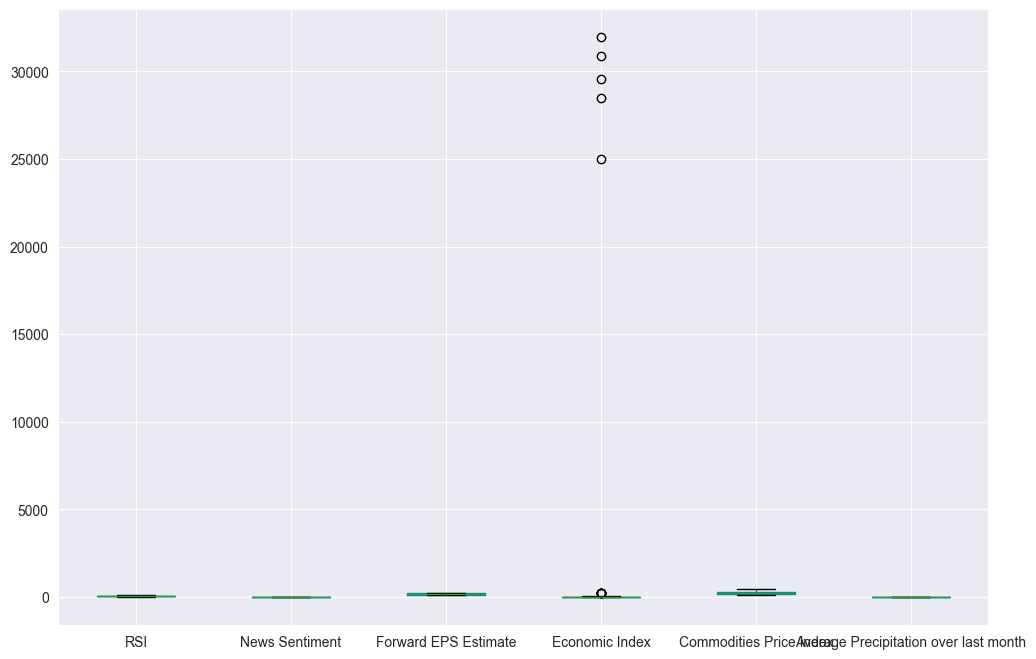

In [72]:
#visual outliers
boxplot(df)

Number of outliers per column:
Stock Market                             0
RSI                                      0
News Sentiment                           0
Forward EPS Estimate                     0
Economic Index                           5
Commodities Price Index                  0
Average Precipitation over last month    0
dtype: int64
count      781.000000
mean       197.070697
std       2336.809494
min        -21.043973
25%          0.416015
50%          8.866033
75%         17.989633
max      31953.235004
Name: Economic Index, dtype: float64


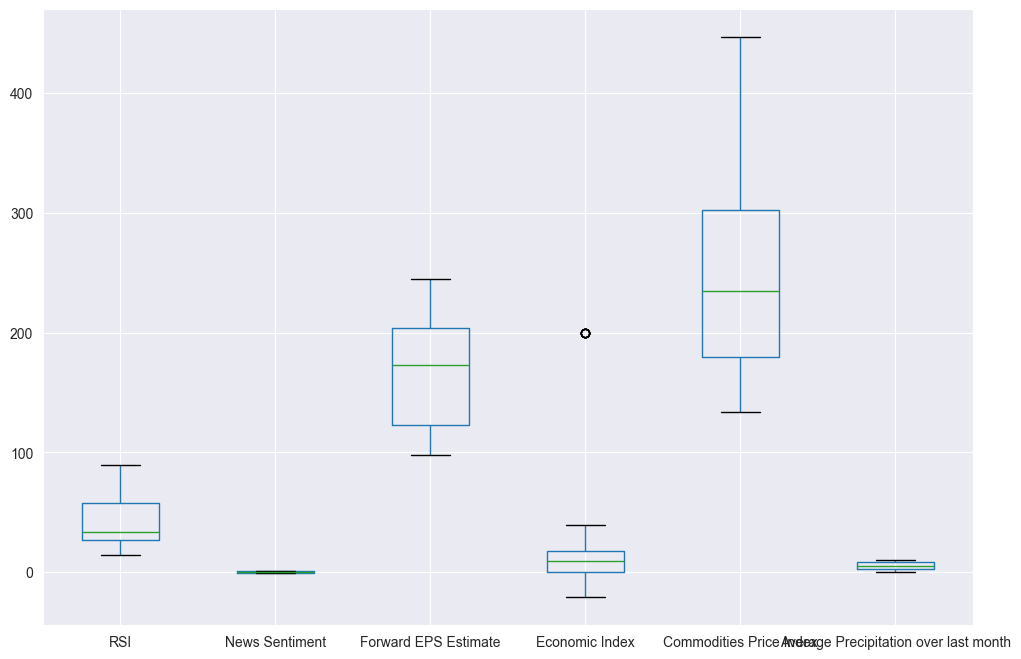

In [73]:
#fix outliers and inspect again. We're left with one, given the low entropy of the feature, it'll get cleaned later
df = handle_outliers(df)
boxplot(df)

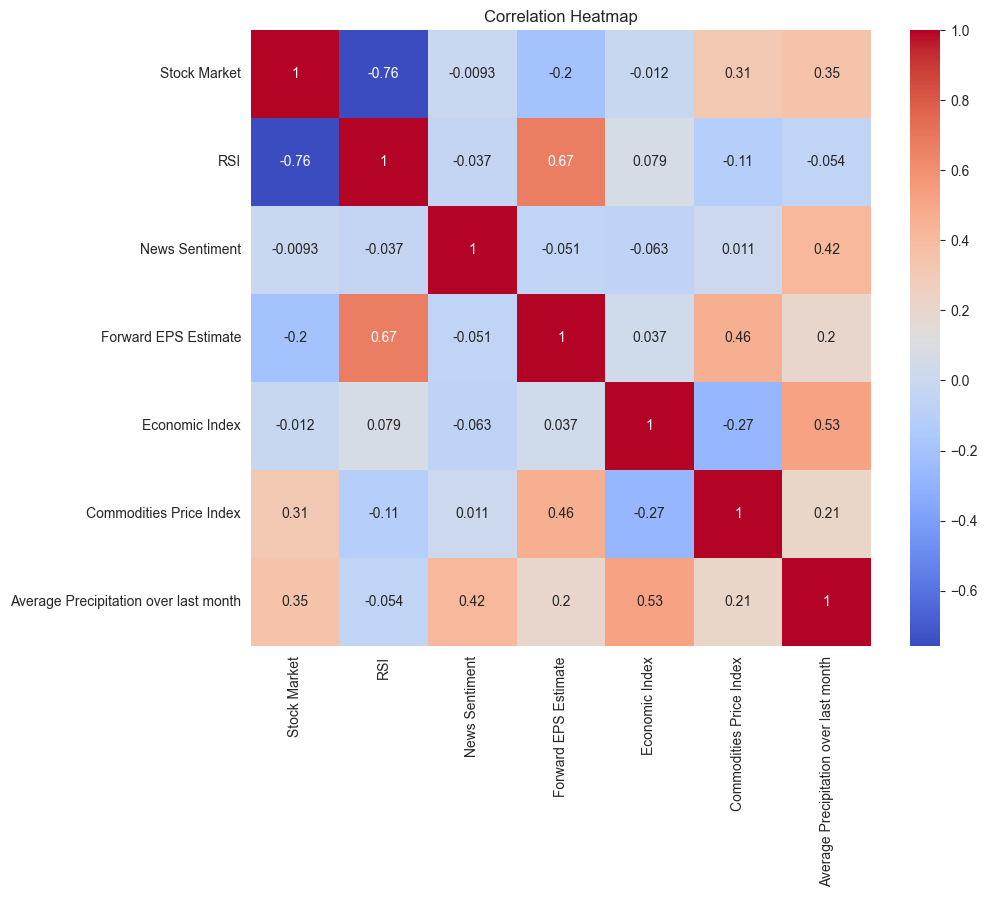

In [74]:
#before any gradiant boosting, inspect correlations and whether there's any simple features (RSI seems only one, we'll come back to this)
correlation_matrix = df[numeric_cols.columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [75]:
#going to use gradiant boosting to self optimise. Will identify weak features, so for now going to use them all.
features = ['RSI', 'News Sentiment', 'Forward EPS Estimate', 'Economic Index', 'Commodities Price Index', 'Average Precipitation over last month']
X = df[features]
Y = df['Stock Market']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [76]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error: %.3f" % mse)
print("R-squared: %.3f" % r2)


Mean squared error: 22023.942
R-squared: 0.990


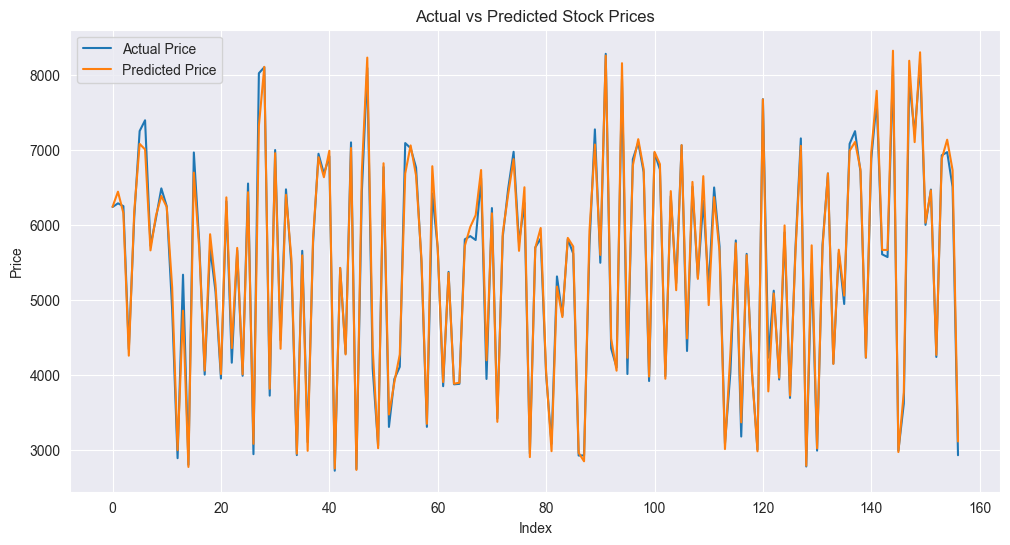

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

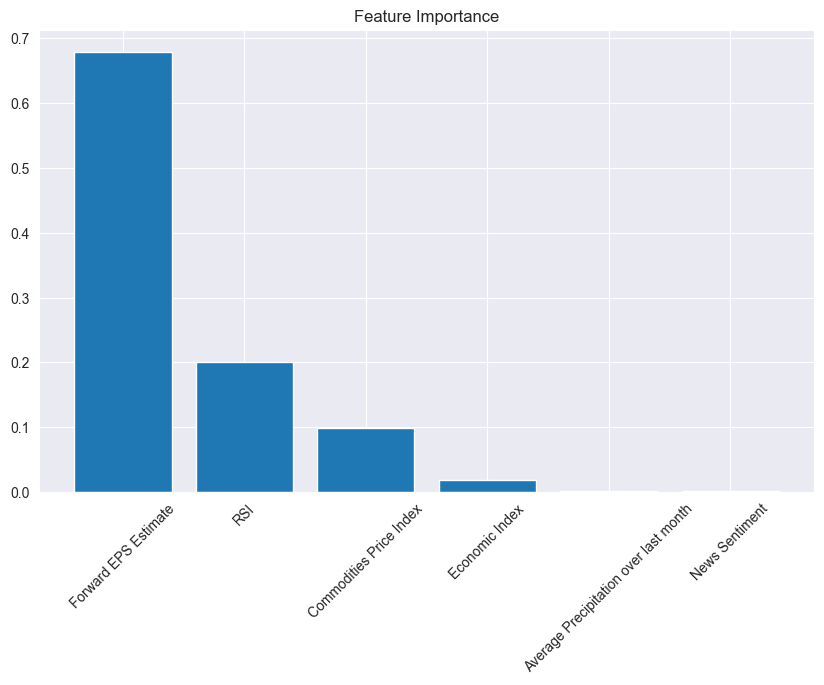

In [57]:
# Feature Importance Visualization
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [58]:
# Drop low-importance features and retrain
low_importance_features = importance_df[importance_df['Importance'] < 0.05]['Feature'].tolist()
print("Dropping low-importance features:", low_importance_features)

# Filter remaining features
X = df[features]
X = X.drop(columns=low_importance_features)
Y = df['Stock Market']

# Retrain with reduced features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Re-evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Updated Mean Squared Error:", mse)
print("Updated R-Squared:", r2)

Dropping low-importance features: ['Economic Index', 'Average Precipitation over last month', 'News Sentiment']
Updated Mean Squared Error: 21344.35358895282
Updated R-Squared: 0.9904836402927879


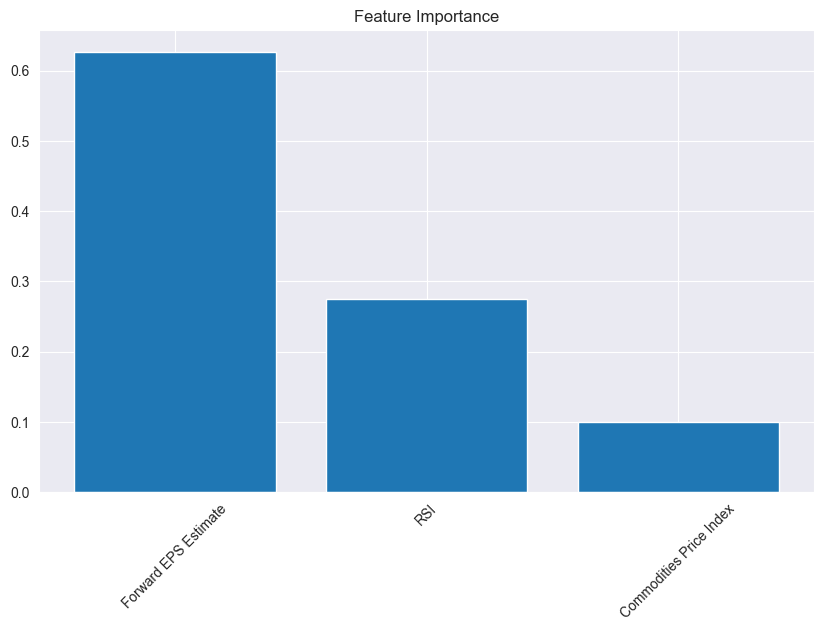

In [59]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

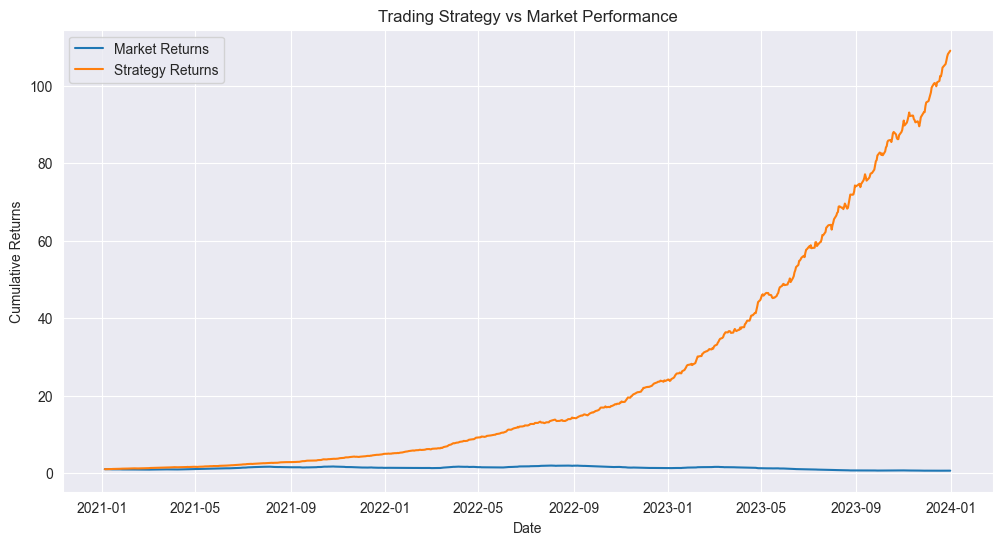

Total Strategy Return: 10805.560131240009 %
Total Market Return: -37.955678840229865 %


In [60]:
# Generate Trading Signals
df['Predicted'] = model.predict(X)  # Predict for entire dataset
df['Signal'] = np.where(df['Predicted'].shift(1) < df['Predicted'], 1, -1)  # Buy/Sell Signal
df['Daily_Return'] = np.log(df['Stock Market']/df['Stock Market'].shift(1))

# Calculate Strategy Returns
df['Strategy_Return'] = df['Signal'] * df['Daily_Return']

# Cumulative Returns for Strategy vs Market
cumulative_market = (1 + df['Daily_Return']).cumprod()
cumulative_strategy = (1 + df['Strategy_Return']).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], cumulative_market, label='Market Returns')
plt.plot(df['Date'], cumulative_strategy, label='Strategy Returns')
plt.title('Trading Strategy vs Market Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Performance Metrics
total_return_strategy = cumulative_strategy.iloc[-1] - 1
total_return_market = cumulative_market.iloc[-1] - 1

print("Total Strategy Return:", total_return_strategy * 100, "%")
print("Total Market Return:", total_return_market * 100, "%")



In [61]:
# Add a feature to check if RSI is overbought/oversold
df['RSI_Status'] = np.where(df['RSI'] > 70, 1, np.where(df['RSI'] < 30, -1, 0))

# Optimize SMA and RSI thresholds
best_sma_short = 20
best_sma_long = 50
best_rsi_overbought = 70
best_rsi_oversold = 30
best_sharpe_ratio = -np.inf

for sma_short in range(10, 51, 10):
    for sma_long in range(50, 201, 50):
        for rsi_overbought in range(60, 81, 5):
            for rsi_oversold in range(20, 41, 5):
                # Calculate SMAs
                df['SMA_Short'] = df['Stock Market'].rolling(window=sma_short).mean()
                df['SMA_Long'] = df['Stock Market'].rolling(window=sma_long).mean()

                # Drop rows with NaN caused by rolling windows
                temp_data = df.dropna().copy()

                # Generate signals based on combined SMA and RSI conditions
                temp_data['Signal'] = np.where((temp_data['SMA_Short'] > temp_data['SMA_Long']) & (temp_data['RSI'] < rsi_oversold), 1, 0)
                temp_data['Signal'] = np.where((temp_data['SMA_Short'] < temp_data['SMA_Long']) & (temp_data['RSI'] > rsi_overbought), -1, temp_data['Signal'])
                temp_data['Position'] = temp_data['Signal'].diff()

                # Calculate returns
                temp_data['Strategy_Return'] = temp_data['Position'].shift(1) * temp_data['Stock Market'].pct_change()
                cumulative_strategy = (1 + temp_data['Strategy_Return']).cumprod()

                # Calculate Sharpe Ratio
                sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()

                # Update best parameters
                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_sma_short = sma_short
                    best_sma_long = sma_long
                    best_rsi_overbought = rsi_overbought
                    best_rsi_oversold = rsi_oversold

print(f"Best SMA Short: {best_sma_short}, Best SMA Long: {best_sma_long}")
print(f"Best RSI Overbought: {best_rsi_overbought}, Best RSI Oversold: {best_rsi_oversold}")

# Final Strategy with Optimized Parameters
df['SMA_Short'] = df['Stock Market'].rolling(window=best_sma_short).mean()
df['SMA_Long'] = df['Stock Market'].rolling(window=best_sma_long).mean()
df.dropna(inplace=True)
df['Signal'] = np.where((df['SMA_Short'] > df['SMA_Long']) & (df['RSI'] < best_rsi_oversold), 1, 0)
df['Signal'] = np.where((df['SMA_Short'] < df['SMA_Long']) & (df['RSI'] > best_rsi_overbought), -1, df['Signal'])
df['Position'] = df['Signal'].diff()

# Calculate Strategy Returns
df['Daily_Return'] = df['Stock Market'].pct_change()
df['Strategy_Return'] = df['Position'].shift(1) * df['Daily_Return']
cumulative_strategy = (1 + df['Strategy_Return']).cumprod()



C:\Users\farro\AppData\Local\Temp\ipykernel_32056\4175492687.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()
C:\Users\farro\AppData\Local\Temp\ipykernel_32056\4175492687.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()
C:\Users\farro\AppData\Local\Temp\ipykernel_32056\4175492687.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()
C:\Users\farro\AppData\Local\Temp\ipykernel_32056\4175492687.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()
C:\Users\farro\AppData\Local\Temp\ipykernel_32056\4175492687.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sha

Best SMA Short: 10, Best SMA Long: 100
Best RSI Overbought: 65, Best RSI Oversold: 30


In [62]:

# Performance Metrics
print("Total Strategy Return:", (cumulative_strategy.iloc[-1] * 100).round(2), "%")
print("Total Market Return:", (total_return_market * 100).round(2), "%")

Total Strategy Return: 234.82 %
Total Market Return: -37.96 %


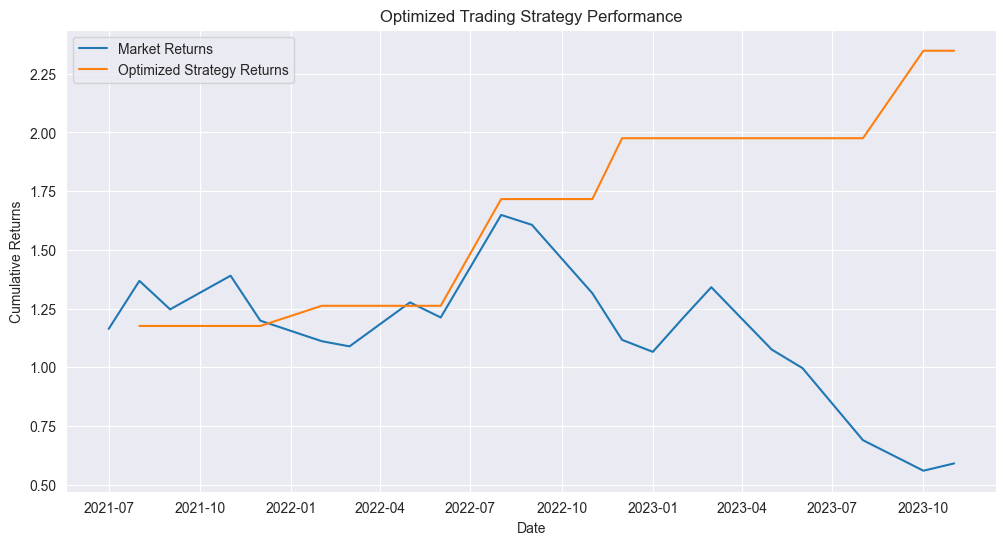

In [63]:
# Plot Optimized Strategy Results
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], (1 + df['Daily_Return']).cumprod(), label='Market Returns')
plt.plot(df['Date'], cumulative_strategy, label='Optimized Strategy Returns')
plt.title('Optimized Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

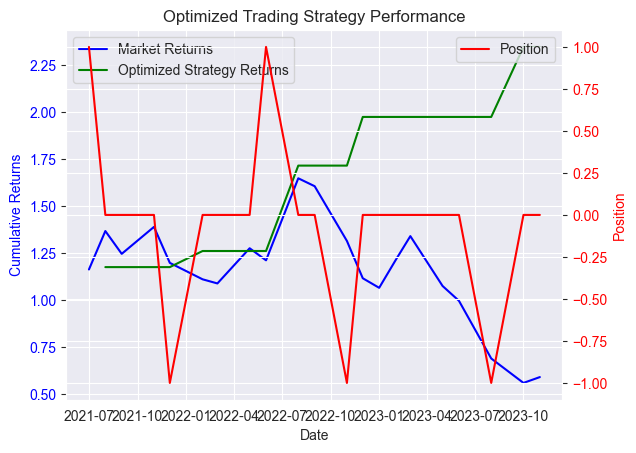

In [64]:
fig, ax1 = plt.subplots()

# Plot Market Returns on the first y-axis (ax1)
ax1.plot(df['Date'], (1 + df['Daily_Return']).cumprod(), label='Market Returns', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Optimized Strategy Returns on the first y-axis (ax1)
ax1.plot(df['Date'], cumulative_strategy, label='Optimized Strategy Returns', color='green')

# Create a second y-axis (ax2) for the Position
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Position'], color='red', label='Position')
ax2.set_ylabel('Position', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and grid
plt.title('Optimized Trading Strategy Performance')
ax1.grid(True)

# Combine legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()